In [1]:
%matplotlib inline

In [2]:
import pickle
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
Characterisation_Set = pickle.load(open("Battery_Data/new_battery_cycles/Characterisation_Set_Complete.p", 'rb'))

def scale(X, torch=False):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    if torch:
        raise Exception("Not implement yet")
    else:
        X_min = X.min()
        X_max = X.max()
        
    return (X - X_min)/(X_max - X_min), X_min, X_max   

In [4]:
SoC, SoC_min, SoC_max = scale(Characterisation_Set["SoC"].T)
Current, Current_min, Current_max = scale(Characterisation_Set["Current"].T)
# Voltage, Voltage_min, Voltage_max = scale(Characterisation_Set["Voltage"].T)
Voltage = Characterisation_Set["Voltage"].T
Characterisation_Set["preprocessing"] = {
    "SoC": (SoC_max, SoC_min),
    "Current": (Current_max, Current_min)
}

In [8]:
Characterisation_Set['Sets'][0].keys()

dict_keys(['SoC', 'Current', 'Voltage'])

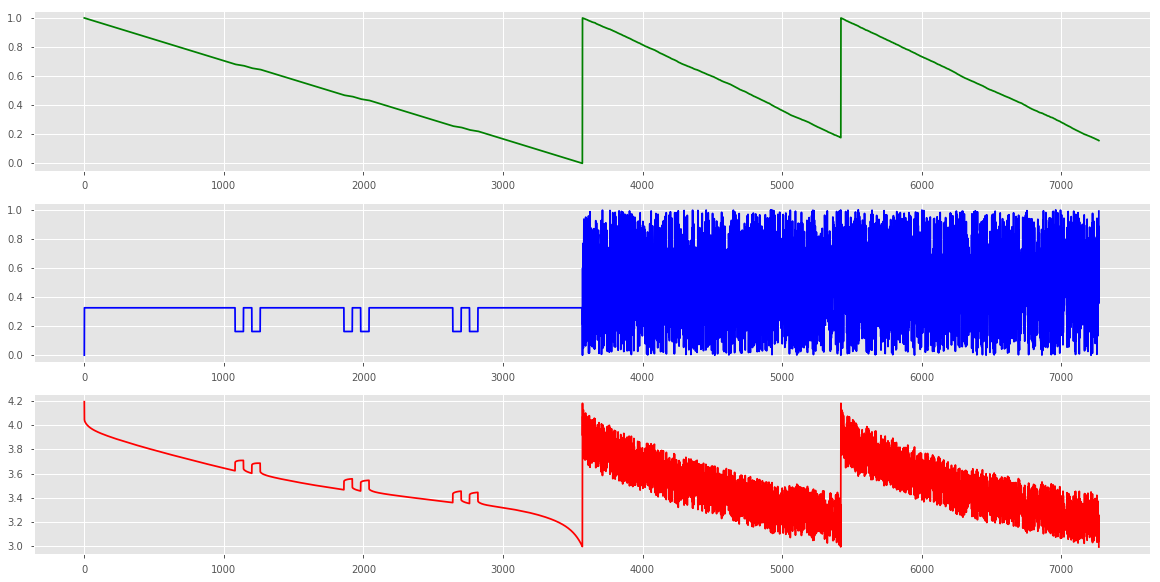

In [5]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.figure("Characterisation_Set")
plt.subplot(311)
plt.plot(SoC, '-g')
plt.subplot(312)
plt.plot(Current, '-b')
plt.subplot(313)
plt.plot(Voltage, '-r')
plt.show()

In [6]:
class Naive_Battery_RNN(nn.Module):
    def __init__(self, p=0.25):
        super(Naive_Battery_RNN, self).__init__()
        self.p = p
        self.V_hl1 = nn.Linear(2, 1024)
        self.V_hl2 = nn.Linear(1024, 512)
        self.V = nn.Linear(512, 1)
        
        self.EnergyLoss_hl1 = nn.Linear(2, 1024)
        self.EnergyLoss_hl2 = nn.Linear(1024, 512)
        self.EnergyLoss = nn.Linear(512, 1)
                
    def forward(self, soc_init, current):
        
        voltage = torch.empty(current.shape, dtype=torch.float)
        soc_hist = torch.empty(current.shape, dtype=torch.float)
        soc = torch.Tensor([[soc_init]])
        soc = soc.to(device, torch.float)
        for t in range(current.shape[1]):
            I = torch.Tensor([[current[0, t]]])
            I = I.to(device, torch.float)
            
            # Estimate Energy Loss
            combined = torch.cat((soc, I), 1)
            Energy_Lost = torch.sigmoid(self.EnergyLoss_hl1(combined))
            Energy_Lost = F.dropout(Energy_Lost, training=self.training, p=self.p)
            Energy_Lost = torch.sigmoid(self.EnergyLoss_hl2(Energy_Lost))
            Energy_Lost = F.dropout(Energy_Lost, training=self.training, p=self.p)
            Energy_Lost = self.EnergyLoss(Energy_Lost)
            
             # Predict SoC
            soc = soc - Energy_Lost
            soc_hist[0, t] = soc
            
            # Bound SoC
            max_test = soc[:, 0] > 1.0
            soc[max_test, 0] = 1.0
            min_test = soc[:, 0] < 0.0
            soc[min_test, 0] = 0.0000000001 

            # Estimate V
            combined = torch.cat((soc, I), 1)
            V = torch.sigmoid(self.V_hl1(combined))
            V = F.dropout(V, training=self.training, p=self.p)
            V = torch.sigmoid(self.V_hl2(V))
            V = F.dropout(V, training=self.training, p=self.p)
            V = self.V(V)
            voltage[0, t] = V
        
        return voltage, soc_hist

In [7]:
battery = Naive_Battery_RNN()

In [8]:
# init
for W in battery.parameters():
    nn.init.normal_(W)

In [9]:
# Loss and optimizer
criterion = nn.MSELoss()# Mean Squared Loss
# The weight_decay option implements L2 regularisation
optimizer = optim.Adam(battery.parameters(), weight_decay=0.00025) 

In [10]:
# Train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
battery.to(device)

Naive_Battery_RNN(
  (V_hl1): Linear(in_features=2, out_features=1024, bias=True)
  (V_hl2): Linear(in_features=1024, out_features=512, bias=True)
  (V): Linear(in_features=512, out_features=1, bias=True)
  (EnergyLoss_hl1): Linear(in_features=2, out_features=1024, bias=True)
  (EnergyLoss_hl2): Linear(in_features=1024, out_features=512, bias=True)
  (EnergyLoss): Linear(in_features=512, out_features=1, bias=True)
)

In [12]:
import time
import math

epochs = 2500
running_loss = 0.0
loss_min = 1e10
loss_hist = []
    
battery.eval()
start = time.time()

def timeSince(since):
    now = time.time()
    interval = now - since
    m = math.floor(interval / 60)
    s = interval - m * 60
    return '%dm %ds' % (m, s), now, interval

for epoch in range(epochs):
    count = -1
    avg_loss = 0
    loss_set_hist = []
    
    for set_dict in Characterisation_Set['Sets']:
        count += 1
        V = torch.from_numpy(set_dict['Voltage']).float()
        optimizer.zero_grad()
        V_est, SoC = battery(set_dict['SoC'][0, 0], set_dict['Current'])
        loss = criterion(V_est, V)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        loss_set_hist.append(loss.item())
    loss_hist.append(loss_set_hist)
    avg_loss /= (count+1)
    if epoch % 5 == 0:
        now_string, now, interval = timeSince(start)
        remaining_epochs = epochs-(epoch+1)
        remaining_time = interval*remaining_epochs/(epoch + 1)
        h_f = remaining_time / 60.0 / 60.0
        h = math.floor(h_f)
        m_f = (h_f - h)*60.0
        m = math.floor(m_f)
        s = (m_f - m)*60.0
        remaining_string = '%dh %dm %ds' % (h, m, s)
        print("epoch {}, time since start: {}, estimated remaining time: {}".format(epoch, now_string, remaining_string))
    if avg_loss < loss_min:
        print("New average minimum: ", avg_loss)
        torch.save(battery.state_dict(), "./Battery_Data/new_battery_cycles/Naive_Battery_RNN_v1.mdl")
        loss_min = avg_loss
            

epoch 0, time since start: 0m 14s, estimated remaining time: 10h 4m 43s
New average minimum:  74.31981976826985
New average minimum:  6.43803612391154
New average minimum:  2.7195332050323486
epoch 5, time since start: 1m 28s, estimated remaining time: 10h 11m 37s
New average minimum:  2.6158575812975564
New average minimum:  0.815874437491099
New average minimum:  0.4916844889521599
epoch 10, time since start: 2m 42s, estimated remaining time: 10h 11m 42s
New average minimum:  0.40284178654352826
New average minimum:  0.12975419561068216
epoch 15, time since start: 3m 59s, estimated remaining time: 10h 20m 33s
New average minimum:  0.08205817267298698
epoch 20, time since start: 5m 17s, estimated remaining time: 10h 25m 7s
New average minimum:  0.062372482071320214
epoch 25, time since start: 6m 34s, estimated remaining time: 10h 25m 13s
New average minimum:  0.04969727620482445
New average minimum:  0.047269467264413834
epoch 30, time since start: 7m 51s, estimated remaining time: 10

epoch 190, time since start: 49m 22s, estimated remaining time: 9h 56m 55s
New average minimum:  0.04051427418986956
New average minimum:  0.040507201105356216
epoch 195, time since start: 50m 38s, estimated remaining time: 9h 55m 12s
New average minimum:  0.04049035285909971
New average minimum:  0.04047218586007754
epoch 200, time since start: 51m 53s, estimated remaining time: 9h 53m 37s
New average minimum:  0.040451180189847946
New average minimum:  0.04044932251175245
New average minimum:  0.04044550036390623
New average minimum:  0.04042566940188408
epoch 205, time since start: 53m 11s, estimated remaining time: 9h 52m 19s
New average minimum:  0.04042049994071325
New average minimum:  0.04041659583648046
New average minimum:  0.040414877235889435
epoch 210, time since start: 54m 27s, estimated remaining time: 9h 50m 50s
New average minimum:  0.040410627921422325
New average minimum:  0.040407445281744
New average minimum:  0.04040554414192835
New average minimum:  0.04040486241

epoch 585, time since start: 147m 25s, estimated remaining time: 8h 1m 31s
epoch 590, time since start: 148m 40s, estimated remaining time: 8h 0m 15s
epoch 595, time since start: 149m 56s, estimated remaining time: 7h 58m 59s
epoch 600, time since start: 151m 12s, estimated remaining time: 7h 57m 46s
epoch 605, time since start: 152m 28s, estimated remaining time: 7h 56m 32s
New average minimum:  0.040133170783519745
epoch 610, time since start: 153m 43s, estimated remaining time: 7h 55m 14s
epoch 615, time since start: 154m 59s, estimated remaining time: 7h 54m 2s
epoch 620, time since start: 156m 14s, estimated remaining time: 7h 52m 46s
epoch 625, time since start: 157m 30s, estimated remaining time: 7h 51m 29s
epoch 630, time since start: 158m 45s, estimated remaining time: 7h 50m 14s
epoch 635, time since start: 159m 59s, estimated remaining time: 7h 48m 54s
epoch 640, time since start: 161m 12s, estimated remaining time: 7h 47m 32s
epoch 645, time since start: 162m 27s, estimated

New average minimum:  0.04010279973347982
New average minimum:  0.04009843245148659
epoch 1120, time since start: 279m 32s, estimated remaining time: 5h 43m 52s
epoch 1125, time since start: 280m 47s, estimated remaining time: 5h 42m 38s
epoch 1130, time since start: 282m 1s, estimated remaining time: 5h 41m 22s
epoch 1135, time since start: 283m 16s, estimated remaining time: 5h 40m 7s
epoch 1140, time since start: 284m 31s, estimated remaining time: 5h 38m 53s
epoch 1145, time since start: 285m 45s, estimated remaining time: 5h 37m 37s
epoch 1150, time since start: 286m 59s, estimated remaining time: 5h 36m 21s
epoch 1155, time since start: 288m 13s, estimated remaining time: 5h 35m 6s
epoch 1160, time since start: 289m 25s, estimated remaining time: 5h 33m 47s
epoch 1165, time since start: 290m 38s, estimated remaining time: 5h 32m 30s
epoch 1170, time since start: 291m 49s, estimated remaining time: 5h 31m 11s
epoch 1175, time since start: 293m 2s, estimated remaining time: 5h 29m 

epoch 1650, time since start: 409m 57s, estimated remaining time: 3h 30m 48s
epoch 1655, time since start: 411m 9s, estimated remaining time: 3h 29m 32s
epoch 1660, time since start: 412m 22s, estimated remaining time: 3h 28m 17s
epoch 1665, time since start: 413m 33s, estimated remaining time: 3h 27m 1s
epoch 1670, time since start: 414m 45s, estimated remaining time: 3h 25m 46s
epoch 1675, time since start: 415m 57s, estimated remaining time: 3h 24m 30s
epoch 1680, time since start: 417m 10s, estimated remaining time: 3h 23m 15s
epoch 1685, time since start: 418m 23s, estimated remaining time: 3h 21m 59s
epoch 1690, time since start: 419m 36s, estimated remaining time: 3h 20m 44s
epoch 1695, time since start: 420m 49s, estimated remaining time: 3h 19m 29s
epoch 1700, time since start: 422m 1s, estimated remaining time: 3h 18m 14s
epoch 1705, time since start: 423m 14s, estimated remaining time: 3h 16m 59s
epoch 1710, time since start: 424m 27s, estimated remaining time: 3h 15m 44s
ep

epoch 2185, time since start: 539m 50s, estimated remaining time: 1h 17m 32s
epoch 2190, time since start: 541m 2s, estimated remaining time: 1h 16m 18s
epoch 2195, time since start: 542m 10s, estimated remaining time: 1h 15m 3s
epoch 2200, time since start: 543m 2s, estimated remaining time: 1h 13m 46s
epoch 2205, time since start: 543m 55s, estimated remaining time: 1h 12m 29s
epoch 2210, time since start: 544m 48s, estimated remaining time: 1h 11m 12s
epoch 2215, time since start: 545m 40s, estimated remaining time: 1h 9m 56s
epoch 2220, time since start: 546m 33s, estimated remaining time: 1h 8m 39s
epoch 2225, time since start: 547m 25s, estimated remaining time: 1h 7m 23s
epoch 2230, time since start: 548m 18s, estimated remaining time: 1h 6m 6s
epoch 2235, time since start: 549m 10s, estimated remaining time: 1h 4m 50s
epoch 2240, time since start: 550m 3s, estimated remaining time: 1h 3m 34s
epoch 2245, time since start: 550m 56s, estimated remaining time: 1h 2m 18s
epoch 2250,

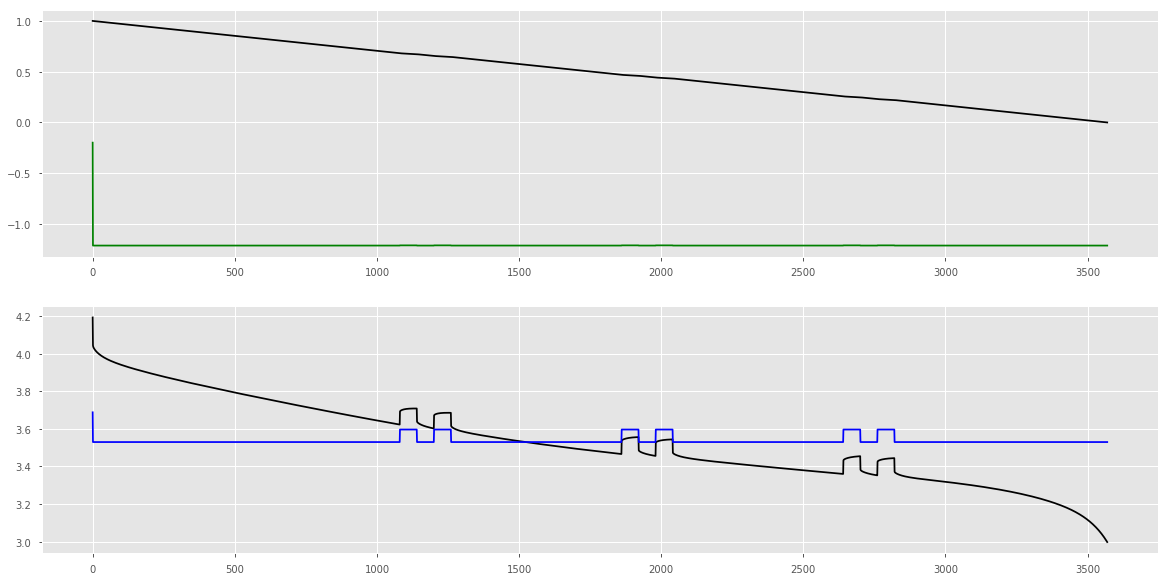

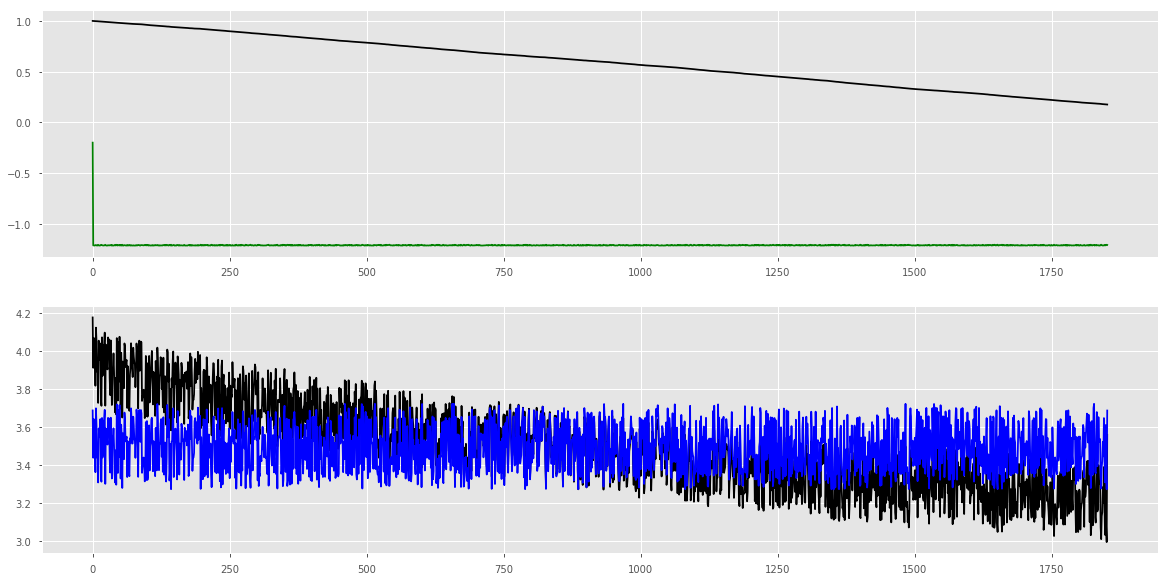

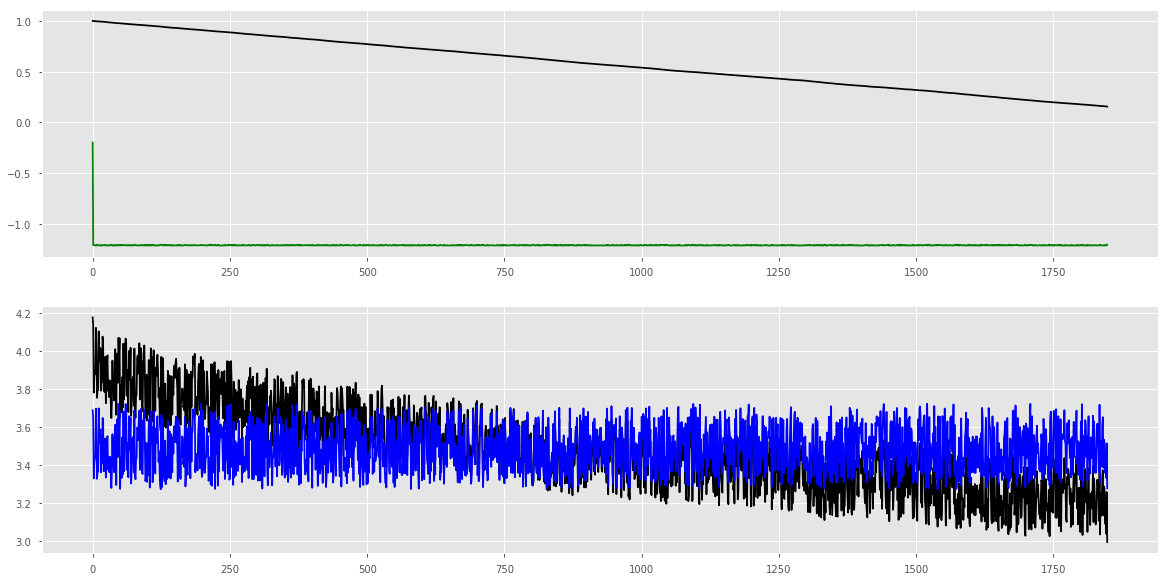

In [14]:
battery = Naive_Battery_RNN()
battery.load_state_dict(torch.load("./Battery_Data/new_battery_cycles/Naive_Battery_RNN_v1.mdl"))
battery.to(device)
battery.eval()

with torch.no_grad():
    for i, set_dict in enumerate(Characterisation_Set['Sets']):
        
        V = torch.from_numpy(set_dict['Voltage']).float()
        V_est, SoC = battery(set_dict['SoC'][0, 0], set_dict['Current'])
        plt.figure(i)
        plt.subplot(2,1,1)
        plt.plot(set_dict['SoC'].T, 'k')
        plt.plot(SoC.to("cpu").numpy().T, 'g')
        plt.subplot(2,1,2)
        plt.plot(V.to("cpu").numpy().T, 'k')
        plt.plot(V_est.to("cpu").numpy().T, 'b')
        